In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/rani700/corona/master/datasets/complete.csv')

In [3]:
data.head()

,Date,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases
0,2020-01-30,Kerala,1,0,0,10.8505,76.2711,0,1
1,2020-01-31,Kerala,1,0,0,10.8505,76.2711,0,1
2,2020-02-01,Kerala,2,0,0,10.8505,76.2711,0,2
3,2020-02-02,Kerala,3,0,0,10.8505,76.2711,0,3
4,2020-02-03,Kerala,3,0,0,10.8505,76.2711,0,3


In [0]:
cases = data.iloc[:, [0, -1, -2]].groupby(['Date']).sum()

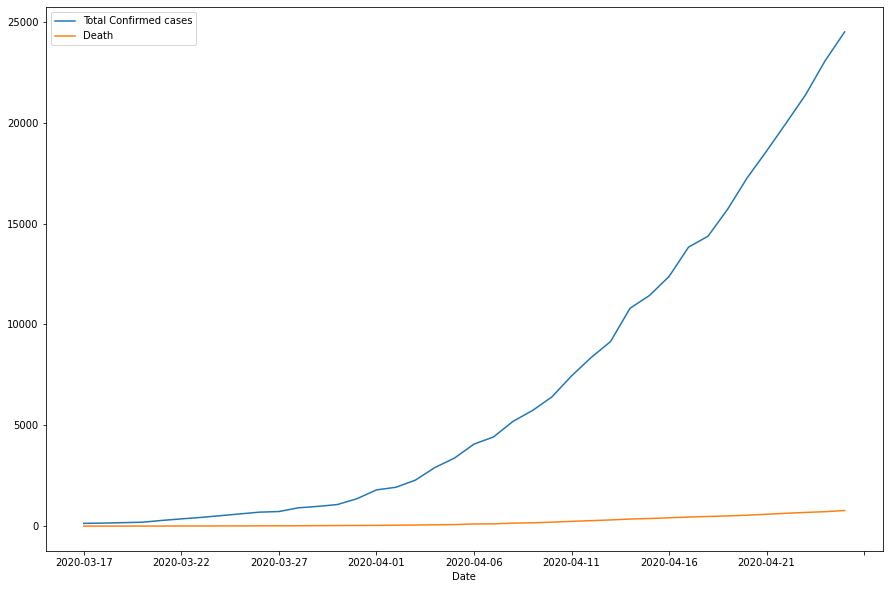

In [5]:
cases[-40:].plot(figsize=(15, 10))
plt.show()

In [0]:
d = cases.iloc[-40:, [0]].values

In [7]:
d.shape

(40, 1)

In [0]:
def getData(data, N_min = 10, N_max = 15, O = 5, P_min = 10, P_max = 15):

  scaler = StandardScaler()
  scaler.fit(data)
  data = scaler.transform(data)

  N_min = N_min
  N_max = N_max
  O = O
  P_min = P_min
  P_max = P_max
  Dimension = 1

  X = []
  y = []

  # VLSW
  for N in range(N_min, N_max+1):
    for P in range(P_min, P_max+1):
      for i in range(len(data) - (N + O + P) +1):
        N_pad = N_max - N
        P_pad = P_max - P

        temp1 = data[i : i+N]
        temp2 = [[0 for __ in range(Dimension)] for _ in range(N_pad)]
        temp3 = [[0 for __ in range(Dimension)] for _ in range(O)]
        temp4 = data[i+N+O : i+N+O+P]
        temp5 = [[0 for __ in range(Dimension)] for _ in range(P_pad)]

        tosave = np.append(np.append(np.append(np.append(temp1, temp2), temp3), temp4), temp5)
        X.append(tosave)
        y.append(data[i+N : i+N+O, 0])
  
  X = np.array(X)
  y = np.array(y)
  X = X.reshape(X.shape[0], Dimension, N_max+O+P_max)

  return X, y, scaler

In [0]:
Output = 5
X, y, scaler = getData(d, O=Output, P_min=0, P_max=0, N_min=10, N_max=16)

In [10]:
X.shape

(161, 1, 21)

In [11]:
y.shape

(161, 5)

In [0]:
from sklearn.model_selection import train_test_split 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [14]:
X_train.shape

(120, 1, 21)

In [15]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.42.0-cp36-none-any.whl size=17296 sha256=162a26963e9c819047f04f8b1c0f45da5594dbc2d1d2e46e8d8344c42b27eba1
  Stored in directory: /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894
Successfully built keras-self-attention


In [16]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM, Bidirectional
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras_self_attention import SeqSelfAttention
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(LSTM(64))
model.add(Dense(Output))
model.compile(optimizer='adam', loss='mse')

In [18]:
model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test))

Train on 120 samples, validate on 41 samples
Epoch 1/50
120/120 [==============================] - 2s 14ms/step - loss: 0.8202 - val_loss: 0.8647
Epoch 2/50
120/120 [==============================] - 0s 318us/step - loss: 0.7766 - val_loss: 0.8379
Epoch 3/50
120/120 [==============================] - 0s 321us/step - loss: 0.7306 - val_loss: 0.8076
Epoch 4/50
120/120 [==============================] - 0s 313us/step - loss: 0.6738 - val_loss: 0.7721
Epoch 5/50
120/120 [==============================] - 0s 308us/step - loss: 0.6084 - val_loss: 0.7291
Epoch 6/50
120/120 [==============================] - 0s 312us/step - loss: 0.5257 - val_loss: 0.6728
Epoch 7/50
120/120 [==============================] - 0s 342us/step - loss: 0.4252 - val_loss: 0.5898
Epoch 8/50
120/120 [==============================] - 0s 338us/step - loss: 0.3244 - val_loss: 0.4802
Epoch 9/50
120/120 [==============================] - 0s 324us/step - loss: 0.2204 - val_loss: 0.3635
Epoch 10/50
120/120 [=================

In [0]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

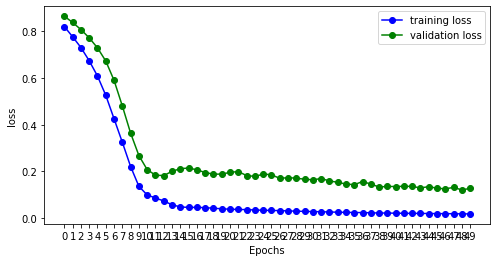

In [27]:
plt.figure(figsize=(8,4))
plt.xticks(np.arange(0,50,1))
plt.plot(range(len(training_loss)),training_loss, 'bo-', label="training loss")
plt.plot(range(len(validation_loss)),validation_loss, 'go-', label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

## Predicting Last 5 days cases for checking model relevance

In [0]:
t1 = scaler.transform(d[-19:-5])
temp = np.append(t1, np.zeros([7, 1])).reshape(-1, 1)
temp = temp.reshape(1, 1, -1)
y_h = model.predict([temp])
y_h = scaler.inverse_transform(y_h)

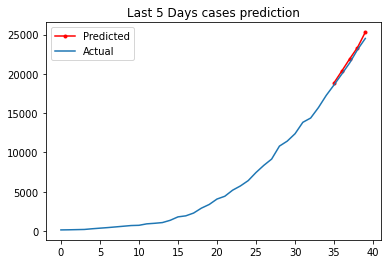

In [31]:
plt.plot(range(35, 40), y_h[0], 'r.-', label="Predicted")
plt.plot(d[-40:].reshape(1, -1)[0], label="Actual")
plt.title("Last 5 Days cases prediction")
plt.legend()
plt.show()

## Predicting Next days Cases

In [0]:
t1 = scaler.transform(d[-14:])
temp = np.append(t1, np.zeros([7, 1])).reshape(-1, 1)
temp = temp.reshape(1, 1, -1)
y_h = model.predict([temp])
y_h = scaler.inverse_transform(y_h)

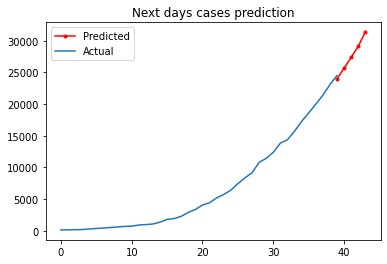

In [33]:
plt.plot(range(39, 44), y_h[0], 'r.-', label="Predicted")
plt.plot(d[-40:].reshape(1, -1)[0], label="Actual")
plt.title("Next days cases prediction")
plt.legend()
plt.show()

In [0]:
# y_h

In [0]:
# 